# combine RNN and ANN

In [49]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
print(sys.path)

['/home/yuan/bio/ml_epitope/rnn', '/home/yuan/anaconda3/envs/py311/lib/python311.zip', '/home/yuan/anaconda3/envs/py311/lib/python3.11', '/home/yuan/anaconda3/envs/py311/lib/python3.11/lib-dynload', '', '/home/yuan/anaconda3/envs/py311/lib/python3.11/site-packages', '/home/yuan/bio/ml_epitope']


In [1]:
import json
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

2025-01-09 09:00:58.557050: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 09:00:58.564430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 09:00:58.573067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 09:00:58.575679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 09:00:58.582217: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


## dataset

In [153]:
filter = lambda x: True if 6<= len(x)<=64 else False

def filter_df(df, frac=None):
    print('original: ', df.shape)
    # drop duplicates
    df = df.drop_duplicates()
    print('duplicated: ', df.shape)
    # filter seq by length
    df = df[df[0].map(filter)]
    print('filtered: ', df.shape)
    if frac:
        df = df.sample(frac=frac)
        print('sampling: ', df.shape)
    return df

In [154]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df1 = filter_df(df1)

original:  (1865242, 2)
duplicated:  (1865242, 2)
filtered:  (1863935, 2)


In [155]:
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df2 = filter_df(df2, .5)

original:  (3185991, 2)
duplicated:  (3185991, 2)
filtered:  (3182717, 2)
sampling:  (1591358, 2)


In [156]:
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)
df3 = filter_df(df3, .5)

original:  (1863999, 2)
duplicated:  (1863998, 2)
filtered:  (1863934, 2)
sampling:  (931967, 2)


In [139]:
# df4 = pd.read_csv('/home/yuan/results/epitope/shuffle.txt', sep='\t', header=None, index_col=None)

In [165]:
df = pd.concat([df1, df2, df3])
df = df.sample(frac=1)
print(df1.shape, df2.shape, df3.shape, df.shape)
df.head()

(1863935, 2) (1591358, 2) (931967, 2) (4387260, 2)


,0,1
1020834,YHVHCADFMQWVWRQECIMN,random
315921,LKHGENIIDT,other
1728231,ERQLPQSTGRKPQCF,epitope
1348063,DSIWQKVLVSSLAFA,epitope
2844956,EEELKEHLL,other


In [166]:
from collections import Counter

# train_data = list(df.iloc[:100_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('random', 'YHVHCADFMQWVWRQECIMN')
Counter({'epitope': 1863935, 'other': 1591358, 'random': 931967})


In [167]:
# embedding
from my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('other', 'NECLWTDML')
split data:  2632356 877452 877452

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: AASNAANDDADTDTD ['A', 'A', 'S', 'N', 'A', 'A', 'N', 'D', 'D', 'A', 'D', 'T', 'D', 'T', 'D']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 2723027), ('A', 2287451), ('S', 2258853), ('G', 2062386), ('E', 2060364), ('V', 2028401), ('K', 1838510), ('P', 1815049), ('T', 1767197), ('R', 1716237), ('D', 1633378), ('I', 1557486), ('Q', 1458001), ('N', 1353685), ('F', 1309575), ('Y', 1125203), ('H', 948508), ('M', 849406), ('C', 781961), ('W', 647716), ('X', 1868), ('U', 34), ('Z', 27), ('B', 15), ('J', 2)])
counts of input: [1117884, 955061, 559411]

## Step 3 encoding: encoding each unique token into integers...


In [160]:
# label, text sequence
train_ds[0]

('epitope', 'KGVPRDFILPISDVR')

## train model

In [203]:
def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

torch.cuda.empty_cache()
print_gpu_memory()

Allocated memory: 65.64 MB
Cached memory: 80.00 MB


In [202]:
import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

In [204]:
from my_dataset import MyDataset
from my_collate import MyCollate
from my_process import MyProcess
from my_rnn_comb import MyRnnComb

from amino_acid.encode_aa import EncodeAA
aa_encoder = EncodeAA()

vocab_size = len(input_vocab)
embedding_dim = 48
num_features = 25
model = MyRnnComb(vocab_size, embedding_dim, num_features).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline, aa_encoder.mean_comp)

num_epochs = 30
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

MyRnnComb(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (rnn_linear): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): ReLU()
  )
  (ann): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=1280, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Epoch 0 acc: 0.7642 val_acc: 0.7769, val_recall: 0.7740
Epoch 1 acc: 0.7786 val_acc: 0.7804, val_recall: 0.7797
Epoch 2 acc: 0.7824 val_acc: 0.7828, val_recall: 0.7810
Epoch 3 acc: 0.7854 val_acc: 0.7823, val_recall: 0.7813
Epoch 4 acc: 0.7874 val_acc: 0.7857, val_recall: 0.7839
Epoch 5 acc: 0.7890 val_acc: 0.7865, val_recall: 0.7852
Epoch 6 acc: 0.7894 val_acc: 0.7865, val_recall: 0.7842
Epoch 7 acc: 0.7910 val_acc: 0.7866, val_recall: 0.7824
Epoch 8 acc: 0.7915 val_acc: 0.7859, va

In [145]:
num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8170 val_acc: 0.8136, val_recall: 0.7425
Epoch 1 acc: 0.8167 val_acc: 0.8139, val_recall: 0.7377
Epoch 2 acc: 0.8186 val_acc: 0.8141, val_recall: 0.7433
Epoch 3 acc: 0.8189 val_acc: 0.8142, val_recall: 0.7382
Epoch 4 acc: 0.8188 val_acc: 0.8142, val_recall: 0.7400
Epoch 5 acc: 0.8196 val_acc: 0.8150, val_recall: 0.7398
Epoch 6 acc: 0.8196 val_acc: 0.8153, val_recall: 0.7411
Epoch 7 acc: 0.8191 val_acc: 0.8145, val_recall: 0.7437
Epoch 8 acc: 0.8197 val_acc: 0.8143, val_recall: 0.7308
Epoch 9 acc: 0.8201 val_acc: 0.8146, val_recall: 0.7521


In [205]:
stat

,acc_train,loss_train,acc_valid,loss_valid,rec_valid
0,0.764170,0.484800,0.776902,0.465344,0.773952
1,0.778601,0.462520,0.780390,0.459942,0.779728
2,0.782385,0.456617,0.782789,0.455267,0.781036
3,0.785384,0.451813,0.782288,0.457223,0.781311
4,0.787386,0.448373,0.785668,0.451322,0.783939
5,0.789037,0.446117,0.786507,0.452912,0.785189
6,0.789361,0.445363,0.786543,0.450921,0.784221
7,0.791015,0.442654,0.786583,0.450061,0.782362
8,0.791463,0.442106,0.785928,0.453708,0.781827
9,0.791648,0.442072,0.786690,0.451191,0.782369


In [206]:
# test predict
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA'
]
res = p.predict(input)
res

,text,predict
0,SSPFLKGFLAGYVVAKLRASAV,0.749350
1,AELMPVGDNN,0.182308
2,AXAXAXAXA,0.002530


In [207]:
print(trained_model.embedding)
print(trained_model.embedding.weight.shape)

Embedding(27, 48, padding_idx=0)
torch.Size([27, 48])


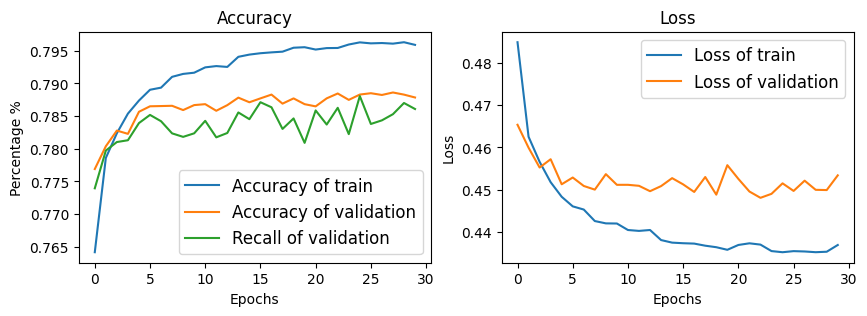

In [208]:
fig = plt.figure(figsize=(10,3))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Accuracy of train")
ax.plot(x_arr, stat.acc_valid, label="Accuracy of validation")
ax.plot(x_arr, stat.rec_valid, label="Recall of validation")
ax.legend(fontsize=12)
# ax.set_ylim(.8, 1)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Loss of train")
ax.plot(x_arr, stat.loss_valid, label="Loss of validation")
ax.legend(fontsize=12)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [209]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.7860995415195535,
 'accuracy': 0.787799218646718,
 'loss': 0.4528389690663039}

In [210]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,NETGQTADGDAAHSA,0.904805,epitope
1,AVIMRGTPQIQRVMTM,0.235419,epitope
2,GRGHLLGRLAAIVAKQVL,0.935228,epitope
3,HGIAKDEYHQSTRSM,0.237436,random
4,SLPNHSEPDHDTDAGLERTNPEYE,0.787168,epitope


373559 503893


Text(0.5, 1.0, 'Distinguish non-epitopes, n = 503893')

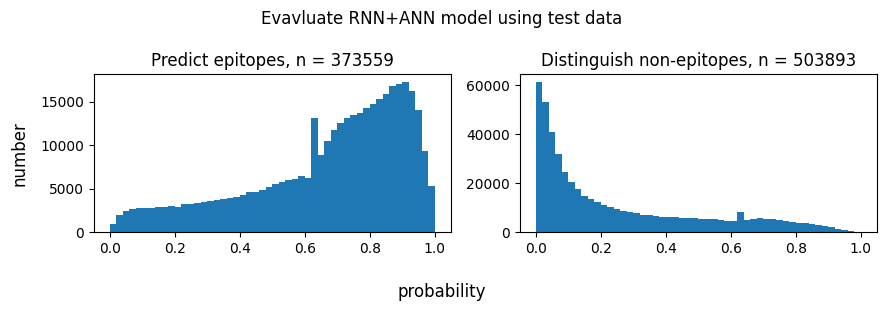

In [214]:
t = pred_test[pred_test['labels']=='epitope']['predict']
f = pred_test[~(pred_test['labels']=='epitope')]['predict']
print(len(t), len(f))

fig, ax = plt.subplots(1, 2, figsize=(9,3), layout='tight')
fig.suptitle('Evavluate RNN+ANN model using test data')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, bins=50)
ax[0].set_title(f'Predict epitopes, n = {len(t)}')
ax[1].hist(f, bins=50)
ax[1].set_title(f'Distinguish non-epitopes, n = {len(f)}')

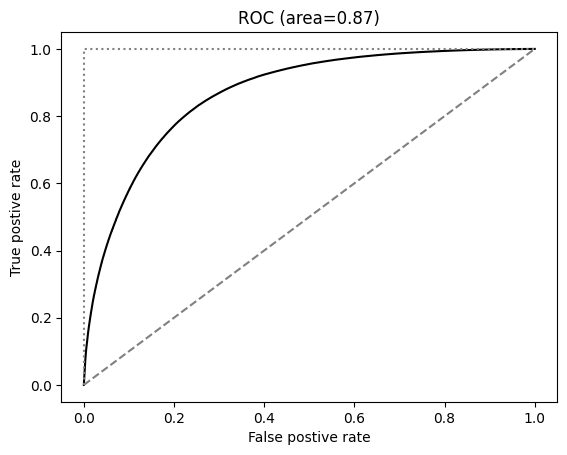

In [212]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(pred_test['labels'], pred_test['predict'], pos_label='epitope')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='black')
plt.title(f'ROC (area={roc_auc:.2f})')
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.plot([0,0,1],[0,1,1], linestyle=':', color='grey')

In [215]:
# save model
torch.save(input_vocab, '../models/epitopes_rnn_vocab.pth')
torch.save(model.state_dict(), '../models/epitopes_rnn_ann.pth')